In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<h2>Image Classifier Using Xception</h2>
<p>Objective : To train a CNN(Convolutional Neural Network) on pre</p>

In [5]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [6]:
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
#import plotly.graph_objects as go
#Matplot Images
import matplotlib.image as mpimg
# Tensflor and Keras Layer and Model and Optimize and Loss
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
#PreTrained Model VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
#Image Generator DataAugmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
# Warnings Remove 
import warnings 
warnings.filterwarnings("ignore")

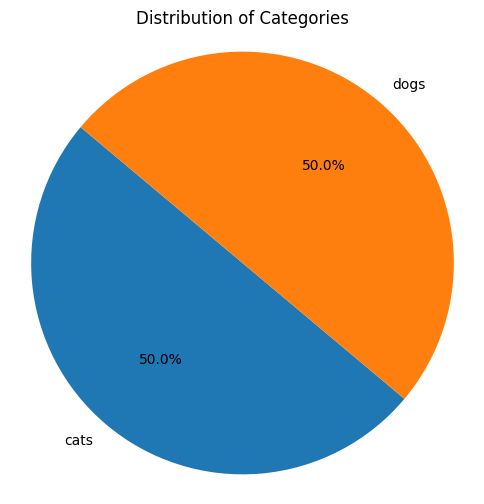

In [8]:
# Count the occurrences of each category in the 'category' column
count = df['category'].value_counts()

# Create a pie chart using Seaborn
plt.figure(figsize=(6, 6) , facecolor='white')
palette = sns.color_palette("tab10")
sns.set_palette(palette)
plt.pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Categories') 
plt.axis('equal') 

plt.show()  # Show the plot

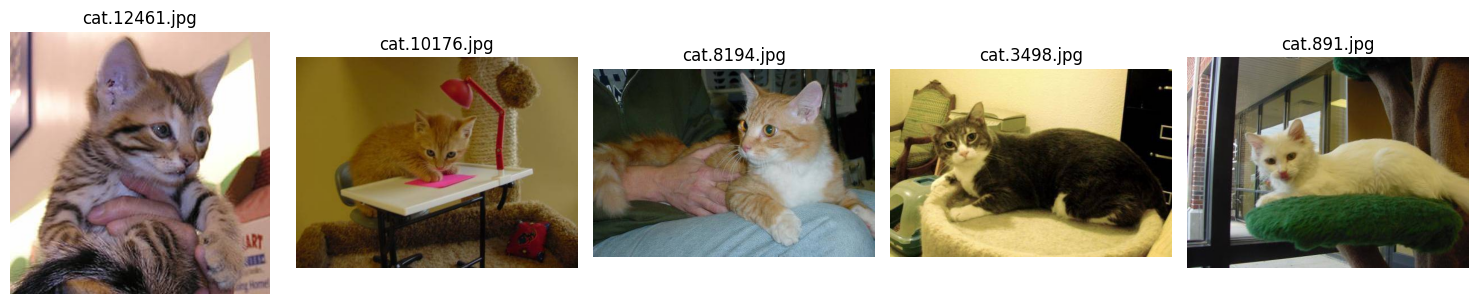

In [9]:
def visualize_images(path, num_images=5):
    # Get a list of image filenames in the specified path
    image_filenames = os.listdir(path )
    
    # Limit the number of images to visualize if there are more than num_images
    num_images = min(num_images, len(image_filenames))
    
    # Create a figure and axis object to display images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='white')
    
    # Iterate over the selected images and display them
    for i, image_filename in enumerate(image_filenames[:num_images]):
        # Load the image using Matplotlib
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        
        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(image_filename)  # Set image filename as title
    
    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

# Specify the path containing the images to visualize
path_to_visualize = "/kaggle/input/dogs-vs-cats/train/cats"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

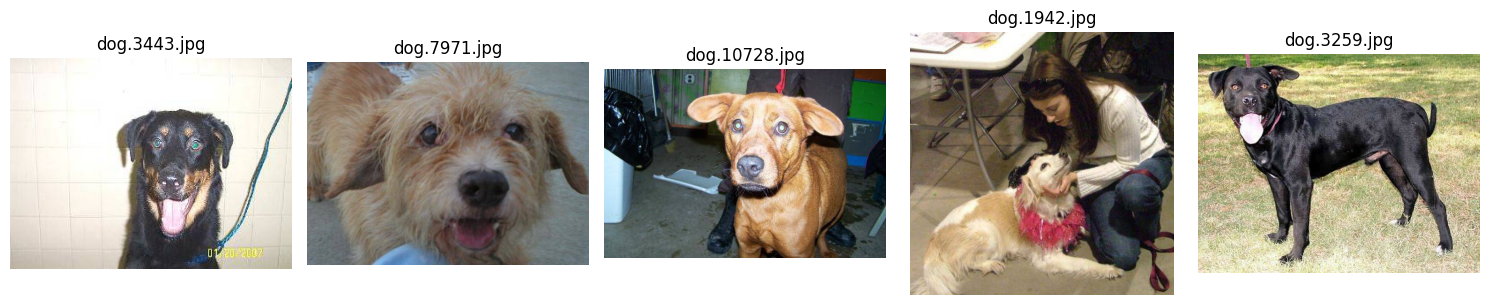

In [10]:
path_to_visualize = "/kaggle/input/dogs-vs-cats/train/dogs" 

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

In [11]:
data_dir = '/kaggle/input/dogs-vs-cats/train'

# Defining data generator with Data Augmentation
data_gen_augmented = ImageDataGenerator(rescale = 1/255., 
                                        validation_split = 0.2,
                                        zoom_range = 0.2,
                                        horizontal_flip= True,
                                        rotation_range = 20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2)
print('Augmented training Images:')
train_ds = data_gen_augmented.flow_from_directory(data_dir, 
                                             target_size = (224, 224), 
                                            batch_size = 32,
                                            subset = 'training',
                                            class_mode = 'binary')

#Testing Augmented Data
# Defining Validation_generator withour Data Augmentation
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

print('Unchanged Validation Images:')
validation_ds = data_gen.flow_from_directory(data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary')

Augmented training Images:
Found 16000 images belonging to 2 classes.
Unchanged Validation Images:
Found 4000 images belonging to 2 classes.


In [12]:
# Load the pre-trained Xception model without the top (classification) layer
xception_base = Xception(weights='imagenet', include_top=False, 
                         input_shape=(224, 224, 3)) 
xception_base.trainable = False

I0000 00:00:1749532810.355305      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749532810.355968      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
import urllib.request
import os

url = "https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
filename = "xception_weights.h5"

if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)
    print("Weights downloaded!")
else:
    print("Weights already exist!")

base_model = Xception(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.load_weights(filename)

Weights downloaded!


In [14]:
# Build the model
model = Sequential()

# Add the pre-trained Xception base
model.add(xception_base)

# Add global average pooling layer to reduce spatial dimensions
model.add(AveragePooling2D(pool_size=(2,2)))

# Flatten the feature maps
model.add(Flatten())

# Add a dense layer with 220 units and ReLU activation function
model.add(Dense(220, activation='relu'))

# Add the output layer with 1 unit and sigmoid activation function for 
# binary classification
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 3, 3, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 220)                 │       4,055,260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             221 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,916,961 (95.05 MB)

 Trainable params: 4,055,481 (15.47 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [16]:
#Compile
model.compile(loss = BinaryCrossentropy(),
        optimizer = keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9),
                metrics = ['accuracy'])

In [17]:
#Early_Stopping
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, 
    restore_best_weights=True,
)

#Fitting Model
history = model.fit(train_ds,
                        epochs= 10,
                        steps_per_epoch = len(train_ds),
                        validation_data = validation_ds,
                        validation_steps = len(validation_ds),
                        callbacks = early_stopping)

Epoch 1/10


I0000 00:00:1749532822.984073     116 service.cc:148] XLA service 0x79fe7883d2b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749532822.985284     116 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749532822.985305     116 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749532823.999093     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/500 ━━━━━━━━━━━━━━━━━━━━ 2:12:20 16s/step - accuracy: 0.5938 - loss: 1.0005

I0000 00:00:1749532832.273828     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 374s 717ms/step - accuracy: 0.9591 - loss: 0.1113 - val_accuracy: 0.9862 - val_loss: 0.0450
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 226s 452ms/step - accuracy: 0.9784 - loss: 0.0572 - val_accuracy: 0.9860 - val_loss: 0.0444
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 227s 454ms/step - accuracy: 0.9815 - loss: 0.0500 - val_accuracy: 0.9868 - val_loss: 0.0427
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 227s 454ms/step - accuracy: 0.9857 - loss: 0.0411 - val_accuracy: 0.9877 - val_loss: 0.0408
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 224s 448ms/step - accuracy: 0.9831 - loss: 0.0470 - val_accuracy: 0.9862 - val_loss: 0.0469
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 224s 448ms/step - accuracy: 0.9884 - loss: 0.0354 - val_accuracy: 0.9870 - val_loss: 0.0377
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 227s 454ms/step - accuracy: 0.9862 - loss: 0.0398 - val_accuracy: 0.9872 - val_loss: 0.0390
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 229s 457ms/step - accuracy: 0.9853 - loss: 0.03

In [18]:
# Evaluate the model on the validation dataset
validation_loss, validation_accuracy = model.evaluate(validation_ds)

# Print the validation loss and accuracy
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - accuracy: 0.9885 - loss: 0.0327
Validation Loss: 0.03557691350579262
Validation Accuracy: 0.9884999990463257


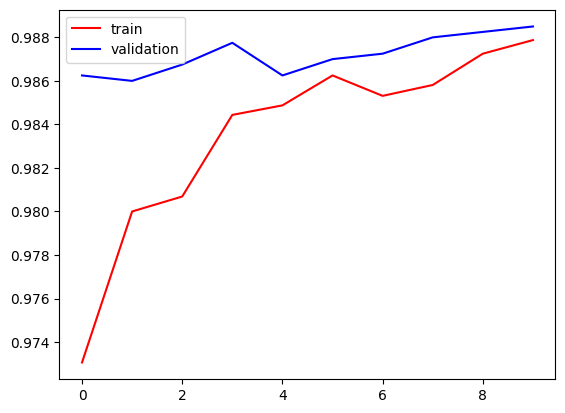

In [19]:
# Accuracy and Val_Accuracy
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

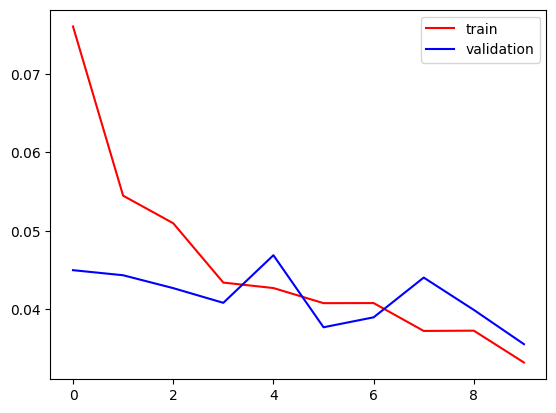

In [20]:
# Loss and Val_Loss
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [21]:
# Get the class indices assigned by the generators
class_indices_train = train_ds.class_indices

# Print the class indices
print("Class indices for training generator:", class_indices_train)

Class indices for training generator: {'cats': 0, 'dogs': 1}


In [22]:
#Testing Augmented Data
test_dir_path = "/kaggle/input/dogs-vs-cats/test"
# Defining Validation_generator withour Data Augmentation
data_test_gen = ImageDataGenerator(rescale = 1/255.)

print('Test Validation Images:')
test_ds = data_gen.flow_from_directory(test_dir_path, 
                                        target_size = (224, 224), 
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary')

Test Validation Images:
Found 1000 images belonging to 2 classes.


In [23]:
# Evaluate the model on the validation dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the validation loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 441ms/step - accuracy: 0.9899 - loss: 0.0182
Test Loss: 0.026970870792865753
Test Accuracy: 0.9890000224113464


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


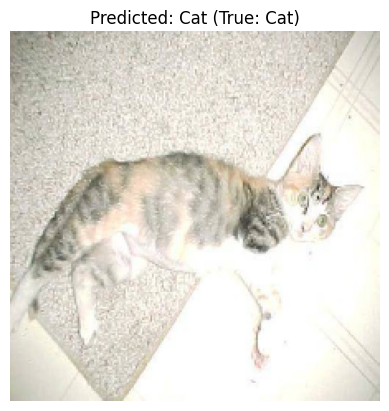

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


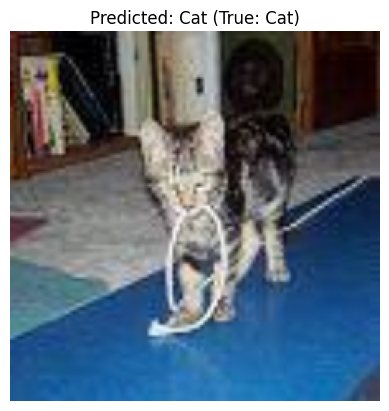

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


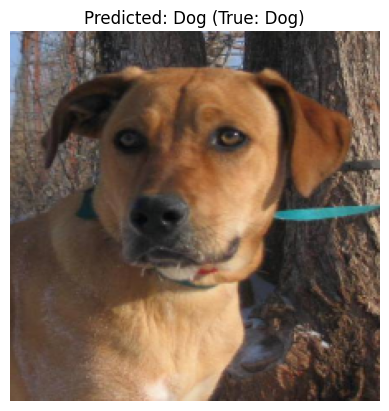

In [24]:
# List of paths to your single images
image_paths = ['/kaggle/input/dogs-vs-cats/train/cats/cat.32.jpg', 
               '/kaggle/input/dogs-vs-cats/train/cats/cat.44.jpg', 
               '/kaggle/input/dogs-vs-cats/train/dogs/dog.51.jpg']
# Intialize true labels
true_labels = ['Cat', 'Cat','Dog']

# Load and preprocess each image, make predictions, and display them 
# using a loop
for img_path, true_label in zip(image_paths, true_labels):
    # Load the image using OpenCV
    img = cv2.imread(img_path)
    # Resize the image to (224, 224)
    img = cv2.resize(img, (224, 224)) 

    # Normalize pixel values
    img_array = img.astype(np.float32) / 255.0  

    # Expand the dimensions to match the input shape expected by the model
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model.predict(img_array)
    actual_prediction = (predictions > 0.5).astype(int)

    # Display the image with true and predicted labels
    # Convert BGR to RGB for displaying with matplotlib
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
    plt.axis('off')
    if actual_prediction[0][0] == 0:
        predicted_label = 'Cat'
    else:
        predicted_label = 'Dog'
    plt.title(f'Predicted: {predicted_label} (True: {true_label})')
    plt.show()